In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import segyio

In [3]:
from ukpgks.segy import read_segy

In [50]:
# 
data,hdr = read_segy('gather_38.segy',coors=True)
print (data.shape)
offsets = hdr.loc[:,'offsets']
times = np.arange(0,data.shape[1]*0.010,0.010)
print ('sampling interval','10 ms')
print ('tmin',times.min(),'tmax',times.max())
print ('offset min',offsets.min(),'offset max',offsets.max())

(1101, 2500)
sampling interval 10 ms
tmin 0.0 tmax 24.990000000000002
offset min 205.0 offset max 109905.0


In [5]:
# function for linear moveout
def linear_moveout(data,times,offsets,velocity):
    """Lineat moveout correted data given constant velocity"""
    
    from scipy.interpolate import interp1d
    
    Nx,Nt = data.shape
    nmo = np.zeros_like(data)
    
    for i in range(Nx):
        # calclutae linear moveout time
        test = times+offsets[i]/velocity 
        # index
        ind = np.argwhere(test>0.0) 
        to = -1*np.ones_like(times)
        to[ind] = test[ind] 
        # returns the indicies of those points in the array to which lie between the points t0 and tmax
        ind = np.where(np.logical_and(to>=times[0],to<=times[len(times)-1])) 
         # Interpolates x, sampled at "t_old" instants
        interpolator = interp1d(times,data[i,:],kind='cubic')
        # output data is sampled at "t_new" instant
        nmo_trace = interpolator(to[ind]) 
        # pad zeros to make same length as original data
        nmo_trace = np.pad(nmo_trace,(0, Nt-nmo_trace.shape[0]),'constant', constant_values=(0, 0)) 

        nmo[i,:] = nmo_trace
    return nmo

In [6]:
data_nmo = linear_moveout(data,times,offsets,8000)

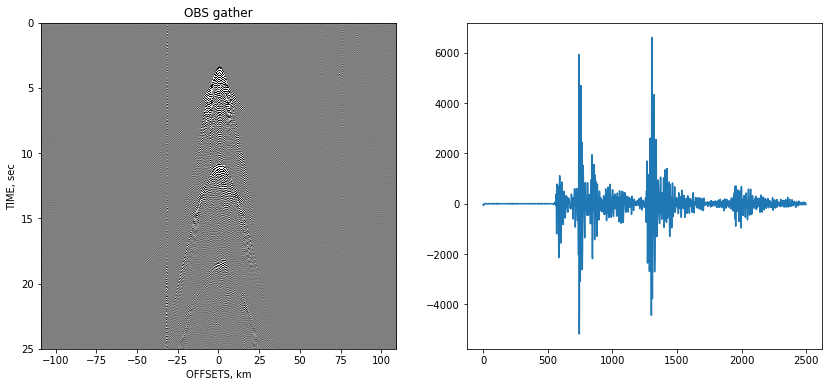

In [66]:
fig,axes = plt.subplots(1,2,figsize=(14,6))
pclip = np.percentile(data,95)
# plt.figure(figsize=(8,6))
axes[0].imshow(data.T,cmap='gray',aspect='auto',vmax=pclip,vmin=-pclip,extent=[-109,109,25,0])
axes[0].set_title('OBS gather')
axes[0].set_xlabel('OFFSETS, km')
axes[0].set_ylabel('TIME, sec')

axes[1].plot(data[600,:])

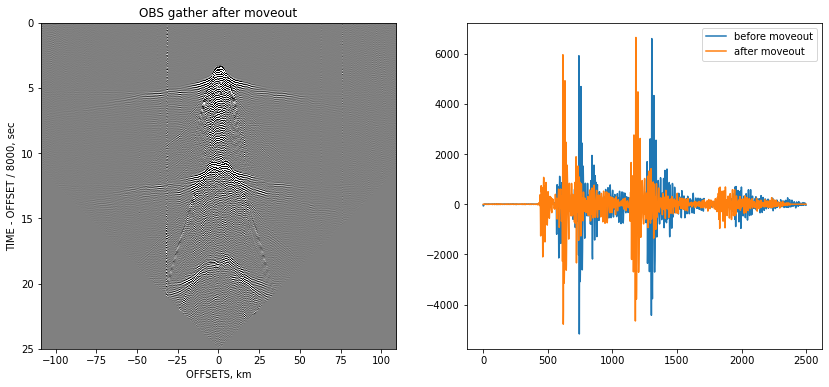

In [67]:
fig,axes = plt.subplots(1,2,figsize=(14,6))
pclip = np.percentile(data_nmo,95)
# plt.figure(figsize=(8,6))
axes[0].imshow(data_nmo.T,cmap='gray',aspect='auto',vmax=pclip,vmin=-pclip,extent=[-109,109,25,0])
axes[0].set_title('OBS gather after moveout')
axes[0].set_xlabel('OFFSETS, km')
axes[0].set_ylabel('TIME - OFFSET / 8000, sec')

axes[1].plot(data[600,:],label='before moveout')
axes[1].plot(data_nmo[600,:],label='after moveout')
axes[1].legend()